In [1]:
from langchain_groq.chat_models import ChatGroq
from typing import TypedDict,Annotated
from langgraph.graph import END,StateGraph,add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.tools import TavilySearchResults
from dotenv import load_dotenv
from uuid import uuid4

load_dotenv()

True

In [2]:
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [3]:
class State(StateGraph):
    messages = Annotated[list,add_messages]

In [4]:
search_tool = TavilySearchResults(search_depth="basic")
tools = [search_tool]

C:\Users\DELL\AppData\Local\Temp\ipykernel_4496\3959453000.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(search_depth="basic")


In [5]:
llm_with_tool  = llm.bind_tools(tools=tools)
memory = MemorySaver()

In [6]:
res = llm_with_tool.invoke("What is weather of AP?")
res

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'q6qqpjdmv', 'function': {'arguments': '{"query":"Andhra Pradesh weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 284, 'total_tokens': 305, 'completion_time': 0.06514629, 'prompt_time': 0.028536294, 'queue_time': 0.051695325, 'total_time': 0.093682584}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ee0e881a-d37a-41b2-bbb5-3c059d6a9080-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Andhra Pradesh weather'}, 'id': 'q6qqpjdmv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 284, 'output_tokens': 21, 'total_tokens': 305})

In [7]:
from langchain_core.messages import AIMessage,HumanMessage,ToolMessage

In [8]:
class State(TypedDict):
    messages : Annotated[list,add_messages]

In [9]:
async def model(state:State):
    result = await llm_with_tool.ainvoke(state['messages'])  
    return {
        "messages": result
    }

In [10]:
async def tool_node(state:State):
    tool_calls = state["messages"][-1].tool_calls
    tool_messages = []
    for tool_call in tool_calls:
        tool_name = tool_call['name']
        tool_args = tool_call['args']
        tool_id = tool_call['id']

        if tool_name == 'tavily_search_results_json':
            search_results = await search_tool.ainvoke(tool_args)
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id = tool_id,
                name = tool_name
            )

            tool_messages.append(tool_message)
    return {"messages":tool_messages}

In [11]:
MODEL = 'model_node'
TOOL_NODE  = 'tool_node'

In [12]:
graph = StateGraph(State)
graph.add_node(MODEL,model)
graph.add_node(TOOL_NODE,tool_node)

def tool_route(state:State):
    last_message = state['messages'][-1]
    if hasattr(last_message,'tool_calls') and len(last_message.tool_calls)>0:
        return TOOL_NODE
    return END

graph.set_entry_point(MODEL)
graph.add_conditional_edges(MODEL,tool_route,path_map={
    "tool_node":TOOL_NODE,
    "__end__":END
})
graph.add_edge(TOOL_NODE,MODEL)
app = graph.compile(checkpointer=memory)

In [13]:
config = {
    "configurable":{
        "thread_id":1
    }
}

In [14]:
res = await app.ainvoke({"messages":"What is the weather in ap?"},config=config)

In [15]:
res

{'messages': [HumanMessage(content='What is the weather in ap?', additional_kwargs={}, response_metadata={}, id='8793e308-a6da-45f2-a9b0-76fff64dab8a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'a6ze8g9g1', 'function': {'arguments': '{"query":"weather in AP"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 285, 'total_tokens': 305, 'completion_time': 0.051844976, 'prompt_time': 0.029097356, 'queue_time': 0.045486414, 'total_time': 0.080942332}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7ecec3f4-9468-4f27-a1c4-27b51413bc7f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in AP'}, 'id': 'a6ze8g9g1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 20, 'total_tokens': 305}),
  ToolMessage(c

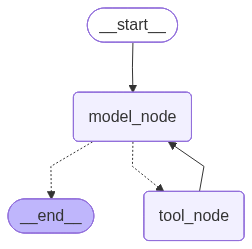

In [16]:
from IPython.display import Image,display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

In [17]:
initial_msg = {"messages":"What is the weather in ap?"}

In [20]:
async for event in app.astream_events(initial_msg,config=config):
    if event['event'] == 'on_chat_model_stream':
        print(event['data']['chunk'].content,end="",flush=True)

The current weather in Andhra Pradesh (AP) is partly cloudy with a temperature of 28°C (82.3°F) and a humidity of 78%. The wind is blowing at 7.6 mph (12.2 kph) from the southwest direction. There is no precipitation, and the visibility is 10 km (6 miles). The feels-like temperature is 32°C (89.6°F), and the UV index is 0.0.